In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import normalize


import os
import pathlib
import sys
import matplotlib.pyplot as plt
from scipy import linalg


sys.path.append(os.path.join(pathlib.Path(os.getcwd()).parent))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from utils.bq_conn import bq_conn_file
# %%
bq_client = bq_conn_file(project_id="dsa-miad-365616")

In [2]:
pd.options.display.max_columns = None

query = '''
SELECT
    *
FROM `Proyecto.DatosSecopI`
ORDER BY anno_cargue_secop DESC
'''
bq_client = bq_conn_file(project_id="dsa-miad-365616")
secop_I = bq_client.execute_query(query=query)
#print(f"El número de filas del dataset: {secop_I.shape[0]}\nEl número de columnas del dataset: {secop_I.shape[1]}")
secop_I.head(5)





,uid,anno_cargue_secop,id_modalidad,modalidad_de_contratacion,estado_del_proceso,id_objeto_a_contratar,detalle_del_objeto_a_contratar,tipo_de_contrato,municipio_de_obtencion,municipios_ejecucion_,departamento_ejecucion,numero_de_proceso,numero_de_contrato,cuantia_proceso,id_grupo,nombre_grupo,id_familia,nombre_familia,id_clase,nombre_clase,id_adjudicacion,tipo_identifi_del_contratista,identificacion_del_contratista,nom_razon_social_contratista,tipo_doc_representante_legal,identific_representante_legal,plazo_de_ejec_del_contrato_,dias_ejec_final_contrato,rango_de_ejec_del_contrato,prorrogado,tiempo_adiciones_en_dias,cuantia_contrato,con_adicion_pptal,valor_total_de_adiciones,valor_contrato_con_adiciones,moneda,objeto_del_contrato_a_la,ruta_proceso_en_secop_i
0,191389136418143424,2019,13,contratacion minima cuantia,celebrado,50000000,contratar servicio suministro elementos materi...,suministro,facatativa,facatativa,cundinamarca,CPMMSFFAMCNo01DE2019,CPMMSFFAMCNO01DE2019,50000000,E,productos de uso final,5022,productos de cereales legumbres,502213,harina productos de molinos,8143424,nit de persona juridica,900791326,inversiones ocazo,cedula de ciudadania,1022363447,330,330,D,0,0,50000000,0,0,50000000,peso colombiano,contratar compra elementos materia prima para ...,{'url': 'https://www.contratos.gov.co/consulta...
1,1912101041779226352,2019,12,contratacion directa ley de,celebrado,53000000,adquisicion uniformes para dotar personal cuer...,prestacion de servicios,bogota,bogota,bogota,DIRGENERALCONTRATACIONDIRECTA184DE2019,184DE2019,22980096902,E,productos de uso final,5310,ropa,531027,uniformes,9226352,nit de persona juridica,860020227,fondo rotatorio de la policia forpo,nit de persona juridica,860020227,660,690,D,1,30,22980096902,0,0,22980096902,peso colombiano,adquisicion uniformes para dotar personal cuer...,{'url': 'https://www.contratos.gov.co/consulta...
2,1912101443259265538,2019,12,contratacion directa ley de,celebrado,55000000,contratar diseno produccion tarjetas presentac...,prestacion de servicios,bogota,bogota,bogota,DIRGENERALCONTRATACIONDIRECTA188DE2019,188DE2019,35998452,E,productos de uso final,5510,medios impresos,551015,publicaciones impresas,9265538,nit de persona juridica,830001113,imprenta nacional de colombia,nit de persona juridica,830001113,31,71,D,1,40,35998452,0,0,35998452,peso colombiano,contratar diseno produccion tarjetas presentac...,{'url': 'https://www.contratos.gov.co/consulta...
3,191294985788644918,2019,12,contratacion directa ley de,liquidado,72000000,prestar servicio mantenimiento preventivo corr...,prestacion de servicios,bogota,bogota,bogota,DIRGENERALCONTRATACIONDIRECTA106DE2019,106DE2019,16767536,F,servicios,7210,servicios de mantenimiento reparaciones de con...,721015,servicios de apoyo para la construccion,8644918,nit de persona juridica,860025639,mitsubishi electric de colombia limitada,nit de persona juridica,860025639,170,170,D,0,0,16767536,0,0,16767536,peso colombiano,prestar servicio mantenimiento preventivo corr...,{'url': 'https://www.contratos.gov.co/consulta...
4,191988590538059861,2019,19,asociacion publico privada,celebrado,73000000,desintegracion vehiculos automotores estado in...,no encontrado en hoja proceso,bogota,bogota,bogota,CONVENIODEASOCIACIÓN231DE2018,231DE2018,0,F,servicios,7318,servicios de maquinado procesado,731810,servicios de maquinado,8059861,nit de persona juridica,806011019,recuperaciones naranjo recycling sas,cedula de ciudadania,57439563,360,360,D,0,0,0,0,0,0,peso colombiano,desintegracion vehiculos automotores estado in...,{'url': 'https://www.contratos.gov.co/consulta...


In [3]:
secopI_filter = secop_I[
    [ 'tipo_de_contrato', 'departamento_ejecucion', 'id_grupo',"cuantia_proceso",'id_objeto_a_contratar',
     'dias_ejec_final_contrato', 'valor_total_de_adiciones']]

secopI_filter
secopI_filter.columns
base = secopI_filter
n = base.isna() == True
base = base.fillna(0)
base.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26553 entries, 0 to 26552
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   tipo_de_contrato          26553 non-null  object
 1   departamento_ejecucion    26553 non-null  object
 2   id_grupo                  26553 non-null  object
 3   cuantia_proceso           26553 non-null  Int64 
 4   id_objeto_a_contratar     26553 non-null  Int64 
 5   dias_ejec_final_contrato  26553 non-null  Int64 
 6   valor_total_de_adiciones  26553 non-null  Int64 
dtypes: Int64(4), object(3)
memory usage: 1.5+ MB


In [4]:
# Codificación de las variables categoricas
#base['estado_del_proceso'] = pd.factorize(base.estado_del_proceso)[0]
base['tipo_de_contrato'] = pd.factorize(base.tipo_de_contrato)[0]
base['departamento_ejecucion'] = pd.factorize(base.departamento_ejecucion)[0]
#base['municipios_ejecucion_'] = pd.factorize(base.municipios_ejecucion_)[0]
base['id_grupo'] = pd.factorize(base.id_grupo)[0]
#base['id_familia'] = pd.factorize(base.id_familia)[0]
#base['id_clase'] = pd.factorize(base.id_clase)[0]
#base['plazo_de_ejec_del_contrato_'] = pd.factorize(base.plazo_de_ejec_del_contrato_)[0]

In [5]:
df = base
df.columns

Index(['tipo_de_contrato', 'departamento_ejecucion', 'id_grupo',
       'cuantia_proceso', 'id_objeto_a_contratar', 'dias_ejec_final_contrato',
       'valor_total_de_adiciones'],
      dtype='object')

<Axes: >

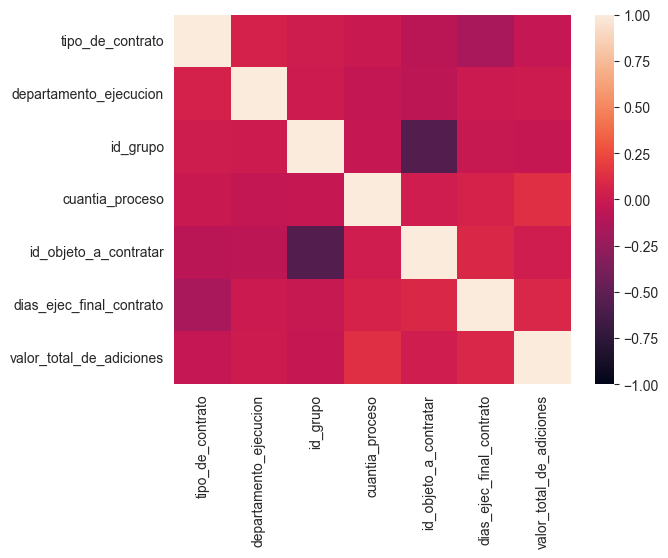

In [7]:
import seaborn as sns
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=False)


In [8]:
train_dataset = df.sample(frac=0.75,random_state=0)
test_dataset = df.drop(train_dataset.index)


train_X = train_dataset.drop(['dias_ejec_final_contrato'], axis=1)
test_X = test_dataset.drop(['dias_ejec_final_contrato'], axis=1)

In [9]:
train_stats = train_X.describe()
train_stats = train_stats.transpose()
train_stats


,count,mean,std,min,25%,50%,75%,max
tipo_de_contrato,19915.0,2.139945,2.329115,0.0,0.0,1.0,5.0,9.0
departamento_ejecucion,19915.0,8.674667,6.704569,0.0,3.0,8.0,12.0,30.0
id_grupo,19915.0,1.137233,1.813211,0.0,0.0,0.0,1.0,6.0
cuantia_proceso,19915.0,20003620.269797,183606265.208702,0.0,1500000.0,4518414.0,16000000.0,22980096902.0
id_objeto_a_contratar,19915.0,47801305.548581,19831937.702627,10000000.0,44000000.0,50000000.0,53000000.0,95000000.0
valor_total_de_adiciones,19915.0,743237.984785,6810707.650352,0.0,0.0,0.0,0.0,412792686.0


In [10]:
train_labels = train_dataset.pop('dias_ejec_final_contrato')
test_labels = test_dataset.pop('dias_ejec_final_contrato')

In [11]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [12]:
[len(train_dataset.keys())]

[6]

In [14]:
def build_model ():
  model = keras.Sequential([
    layers.Dense(6, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(3, activation='relu'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [15]:
model = build_model()

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 42        
                                                                 
 dense_1 (Dense)             (None, 3)                 21        
                                                                 
 dense_2 (Dense)             (None, 1)                 4         
                                                                 
Total params: 67 (268.00 Byte)
Trainable params: 67 (268.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
train_data = np.asarray(normed_train_data).astype(np.float32)
test_data = np.asarray(normed_test_data).astype(np.float32)


In [18]:
example_batch = train_data[:]
example_result = model.predict(example_batch)
example_result

623/623 [==============================] - 0s 329us/step


array([[0.41252956],
       [0.        ],
       [0.08565826],
       ...,
       [0.11459022],
       [0.33248642],
       [0.        ]], dtype=float32)

In [19]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 200

from keras import backend as K
train_data = K.cast_to_floatx(train_data)
train_labels = K.cast_to_floatx(train_labels)

history = model.fit(
  train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................

In [20]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print(hist)

             loss        mae           mse      val_loss    val_mae   
0    30569.732422  79.260391  30569.732422  14706.516602  74.136993  \
1    28803.062500  71.609627  28803.062500  11995.226562  64.626732   
2    25387.898438  66.444244  25387.898438   9056.846680  66.071991   
3    23825.347656  71.685135  23825.347656   8701.274414  70.032654   
4    23695.039062  73.087852  23695.039062   8666.686523  70.340134   
..            ...        ...           ...           ...        ...   
195  23608.855469  72.406403  23608.855469   8930.914062  69.752495   
196  23609.349609  72.407074  23609.349609   8897.732422  69.743538   
197  23607.417969  72.656738  23607.417969   8868.221680  69.443237   
198  23598.191406  72.416969  23598.191406   8884.357422  69.571014   
199  23630.291016  72.734627  23630.291016   8942.696289  69.661186   

          val_mse  epoch  
0    14706.516602      0  
1    11995.226562      1  
2     9056.846680      2  
3     8701.274414      3  
4     8666.6

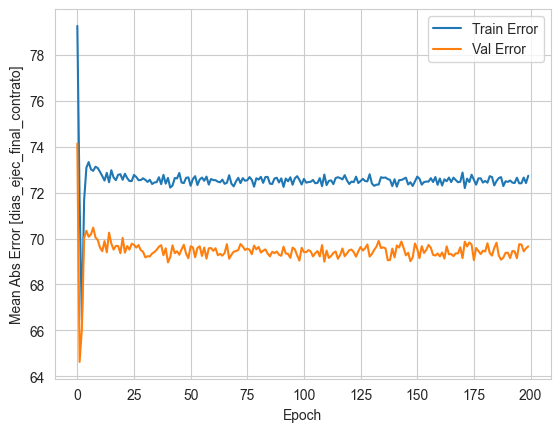

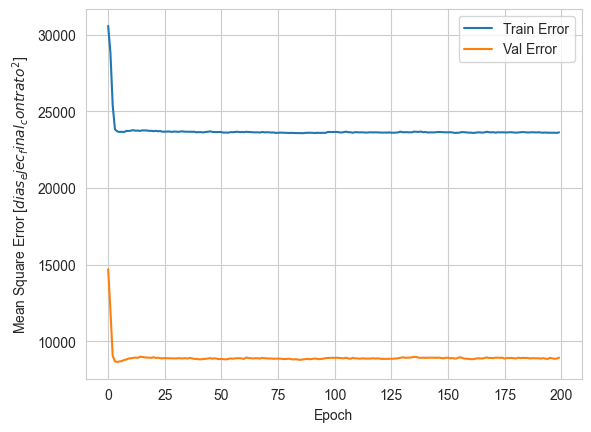

In [21]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [dias_ejec_final_contrato]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$dias_ejec_final_contrato^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.legend()
  plt.show()


plot_history(history)

In [22]:
model_imp = build_model()

In [23]:
test_data = np.asarray(normed_test_data).astype(np.float32)
example_result = model_imp.predict(np.array(test_data[:]))
resultados = pd.DataFrame(example_result)
resultados.columns = ['resultados']
print(resultados)

208/208 [==============================] - 0s 335us/step
      resultados
0       0.274837
1       0.246807
2       0.301772
3       0.301426
4       0.301344
...          ...
6633    0.265977
6634    0.308114
6635    0.283284
6636    0.294510
6637   -0.201060

[6638 rows x 1 columns]


In [24]:
test_data = np.asarray(normed_test_data).astype(np.float32)

In [25]:
test_labels = pd.DataFrame(test_labels)
compare = pd.concat([resultados, test_labels], axis=1)
compare = compare.fillna(0)

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse_t = mean_squared_error(compare['resultados'], compare['dias_ejec_final_contrato'])
mae_t = mean_absolute_error(compare['resultados'], compare['dias_ejec_final_contrato'])
print("El MSE entre las columnas 'Modelo' y 'Dato' es:", mse_t)
print("El MAE entre las columnas 'Modelo' y 'Dato' es:", mae_t)


El MSE entre las columnas 'Modelo' y 'Dato' es: 10474.215286566747
El MAE entre las columnas 'Modelo' y 'Dato' es: 45.24702671557964


In [248]:
weights = model.get_weights()[0]
biases = model.get_weights()[1]

# Imprimir los coeficientes
print("Coeficientes (m):")
for i, w in enumerate(weights):
    print(f"m{i+1}: {w[0]}")

print("")

# Imprimir el sesgo (intercepto) (B)
print("Sesgo (B):")
print(biases[0])

Coeficientes (m):
m1: 0.5656214952468872
m2: -1.01584792137146
m3: 0.49568456411361694
m4: -1.0095285177230835
m5: 0.5721831917762756
m6: -1.020975112915039
m7: -1.8458651304244995
m8: 0.1001221239566803
m9: -0.6604846119880676
m10: -1.2015113830566406
m11: -0.6739510893821716
m12: 1.164045810699463

Sesgo (B):
0.45449907
